# Dogs vs. Cats Dataset Preparation
The dataset can be obtained from the following [link](https://www.microsoft.com/en-us/download/details.aspx?id=54765). It contains 25.000 labeled images and 12.500 unlabeled images. In this case, we will only use the labeled images.

## Plot some Dog and Cat Pictures
Looking at a few random photos in the directory, you can see that the photos are color and have different shapes and sizes.

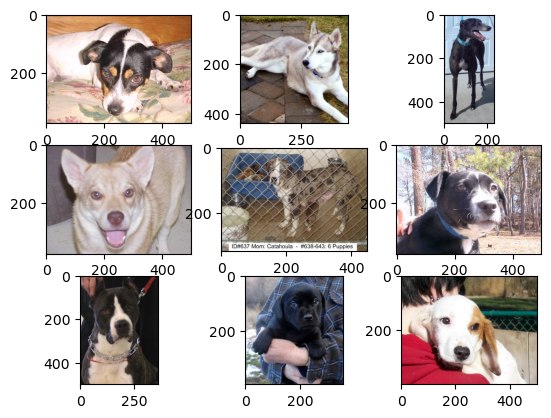

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

folder = '/kaggle/input/cats-vs-dogs/train/dogs/'

for i,f in enumerate(os.listdir(folder)[:9]):
    plt.subplot(331 + i)
    filename = folder + f
    
    # load image pixels
    image = imread(filename)
    plt.imshow(image)

plt.show()

## Remove Invalid/Corrupted Images from the Dataset
Some images in the dataset might be corrupted or have an invalid file extension, so before feeding our models it's necessary to delete these images.

In [2]:
import os
import cv2

dir_ = '/kaggle/input/cats-vs-dogs'
subdir_list=os.listdir(dir_) # create a list of the sub directories in the directory ie train or test

for d in subdir_list:  # iterate through the sub directories train and test
    dpath=os.path.join (dir_, d) # create path to sub directory
    if d == 'train':
        class_list=os.listdir(dpath) # list of classes ie dog or cat
        #print (class_list)
        for klass in class_list: # iterate through the two classes
            class_path=os.path.join(dpath, klass) # path to class directory
            #print(class_path)
            file_list=os.listdir(class_path) # create list of files in class directory

    elif d == 'test':
        file_list=os.listdir(dpath) # list of unlabeled files
        for f in file_list: # iterate through the files
            fpath=os.path.join (dpath,f)
            index=f.rfind('.') # find index of period infilename
            ext=f[index+1:] # get the files extension
            if ext  not in ['jpg', 'png', 'bmp', 'gif']:
                print(f'file {fpath}  has an invalid extension {ext}')
                os.remove(fpath)
            else:
                try:
                    img=cv2.imread(fpath)
                    size=img.shape
                except:
                    print(f'file {fpath} is not a valid image file ')
                    os.remove(fpath)

## Pre-Process Photos into Standard Directories
The photos will have to be reshaped prior to modeling so that all images have the same shape. This is often a small square image. In this case we will choose a fixed size of **224×224 pixels**.

If we want to load all of the images into memory, we can estimate that **it would require more than 12 gigabytes of RAM**. That is 25,000 images with 224x224x3 pixels each, or 3,763,000,000 32-bit pixel values.

Alternately, we can load the images progressively using the Keras `ImageDataGenerator` class and `flow_from_directory()` API. This will be slower than loading the images directly from memory but it will run on more machines.

This API prefers data to be divided into separate `train/` and `test/` directories, and under each directory to have a subdirectory for each class, e.g. a `train/dog/` and a `train/cat/` subdirectories. Images are then organized under the subdirectories.

Our dataset is already organized in this way, so we don't need to write an script to do this.

However, we need to create a validation set. We will randomly select 25% of the images (or 6,250) to be used in the validation set. This can be done consistently by fixing the seed for the pseudorandom number generator so that we get the same split of data each time the code is run.

In [3]:
import os
import random
from shutil import copyfile

def create_validation_set(src_dir, val_ratio=0.25, seed=1):
    # seed random number generator
    random.seed(seed)
    
    # Check whether the validation directory exists.
    if os.path.exists(os.path.join('/kaggle/input/cats-vs-dogs', 'val')):
        print(f"The validation directory already exists.")
        return  # Exit the function if the directory exists
    
    # Create the val directory in the data folder
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = os.path.join('/kaggle/input/cats-vs-dogs', 'val', labldir)
        os.makedirs(newdir, exist_ok=True)
    
    for labldir in  labeldirs:
        # Loop over files in training directory
        for file in os.listdir(os.path.join(src_dir, labldir)):
            if random.random() <= val_ratio:
                # Move the file to the validation directory
                src = os.path.join(src_dir, labldir, file) # Source file path
                dst = os.path.join('/kaggle/input/cats-vs-dogs', 'val', labldir, file) # Destination file path
                copyfile(src, dst)
                os.remove(src) # Remove file from source directory

In [4]:
data_source_dir= os.path.join('/kaggle/input/cats-vs-dogs', 'train')
create_validation_set(data_source_dir)

The validation directory already exists.


Next, we need to prepare the data. This involves first defining an instance of the `ImageDataGenerator` that will scale the pixel values to the range of 0-1.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0)

Next, we need to define some iterators for both the train and validation datasets.

We can use the `flow_from_directory()` function on the data generator and create one iterator for each of the train/ and test/ directories. We must specify that the problem is a binary classification problem via the `class_mode` argument, and to load the images with the size of 224×224 pixels via the `target_size` argument. We will fix the batch size at 64.

In [6]:
# prepare iterators
train_it = datagen.flow_from_directory('/kaggle/input/cats-vs-dogs/train/',
                                       class_mode='binary', batch_size=64, target_size=(224, 224))
val_it = datagen.flow_from_directory('/kaggle/input/cats-vs-dogs/val/',
                                      class_mode='binary', batch_size=64, target_size=(224, 224))

test_it = datagen.flow_from_directory('/kaggle/input/cats-vs-dogs', classes=['test'], target_size=(224, 224), batch_size=64, 
                                      class_mode=None, shuffle=False)

Found 18696 images belonging to 2 classes.
Found 6302 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


We can then fit the model using the train iterator (`train_it`) and use the validation iterator (`val_it`) as a validation dataset during training.

The number of steps for the train and val iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and val directories divided by the batch size (64).

The model will be fit for 20 epochs, a small number to check if the model can learn the problem.

# Develop a Baseline CNN Model
Now, we will develop a baseline convolutional neural network model for the dogs vs. cats dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement. A good starting point is the general architectural principles of the VGG models **(Very Deep Convolutional Neural Networks)**.

This architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can create a function that will define a model and return it ready to be fit on the dataset. This function can then be customized to define different baseline models, e.g. versions of the model with 1, 2, or 3 VGG style blocks.

The model will be fit with stochastic gradient descent and we will start with a conservative learning rate of 0.0005 and a momentum of 0.9.

The problem is a binary classification task, requiring the prediction of one value of either 0 or 1. An output layer with 1 node and a sigmoid activation will be used and the model will be optimized using the binary cross-entropy loss function.

In [7]:
from tensorflow import keras

def define_model(n_blocks, n_filters, learning_rate=0.0005):
    model = keras.models.Sequential()
    for i in range(n_blocks):
        model.add(keras.layers.Conv2D(n_filters[i], (3, 3), activation="relu", kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
        model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # compile model
    opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## One Block VGG Model
The one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.

In [8]:
model = define_model(1, [32])

In [9]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/kaggle/working/models/one_block_vgg.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_it, steps_per_epoch=len(train_it),
                    validation_data=val_it, validation_steps=len(val_it), epochs=20, 
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("/kaggle/working/models/one_block_vgg.h5") # rollback to best model

Epoch 1/20
 52/293 [====>.........................] - ETA: 2:49 - loss: 0.7244 - accuracy: 0.5147

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


293/293 [==============================] - 300s 976ms/step - loss: 0.6918 - accuracy: 0.5381 - val_loss: 0.6751 - val_accuracy: 0.5781
Epoch 2/20
293/293 [==============================] - 107s 365ms/step - loss: 0.6692 - accuracy: 0.5911 - val_loss: 0.6625 - val_accuracy: 0.5989
Epoch 3/20
293/293 [==============================] - 105s 357ms/step - loss: 0.6559 - accuracy: 0.6087 - val_loss: 0.6675 - val_accuracy: 0.5858
Epoch 4/20
293/293 [==============================] - 107s 364ms/step - loss: 0.6406 - accuracy: 0.6239 - val_loss: 0.6310 - val_accuracy: 0.6468
Epoch 5/20
293/293 [==============================] - 104s 356ms/step - loss: 0.6357 - accuracy: 0.6261 - val_loss: 0.6370 - val_accuracy: 0.6222
Epoch 6/20
293/293 [==============================] - 108s 368ms/step - loss: 0.6246 - accuracy: 0.6420 - val_loss: 0.6253 - val_accuracy: 0.6344
Epoch 7/20
293/293 [==============================] - 108s 367ms/step - loss: 0.6151 - accuracy: 0.6511 - val_loss: 0.6250 - val_accura

Once fit, the final model can be evaluated on the validation dataset directly and the classification accuracy reported.

In [10]:
# evaluate model
_, acc = model.evaluate(val_it, steps=len(val_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 67.487


The History contains the model accuracy and loss on the test and training dataset at the end of each epoch. Line plots of these measures over training epochs provide learning curves that we can use to get an idea of whether the model is overfitting, underfitting, or has a good fit.

The summarize_diagnostics() function below takes the history directory and creates a single figure with a line plot of the loss and another for the accuracy. The figure is then saved to file with a filename based on the name of the script. This is helpful if we wish to evaluate many variations of the model in different files and create line plots automatically for each.

In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    
    # plot loss
    axs[0].plot(history.history['loss'], color='blue', label='train')
    axs[0].plot(history.history['val_loss'], color='orange', label='val')
    axs[0].set_title(f'{model_name} - Cross Entropy Loss')
    axs[0].legend()
    axs[0].grid(True)
    
    # plot accuracy
    plt.title(f' {model_name} - Classification Accuracy')
    axs[1].plot(history.history['accuracy'], color='blue', label='train')
    axs[1].plot(history.history['val_accuracy'], color='orange', label='val')
    axs[1].set_title(f' {model_name} - Classification Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # Adjust the spacing between subplots (left, right, bottom, top)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    if not os.path.isdir('/kaggle/working/img/plots/'):
        os.makedirs('/kaggle/working/img/plots/')
    # save plot to file
    plt.savefig('/kaggle/working/img/plots/' + model_name + '_plot.png')
    plt.show()
    plt.close()

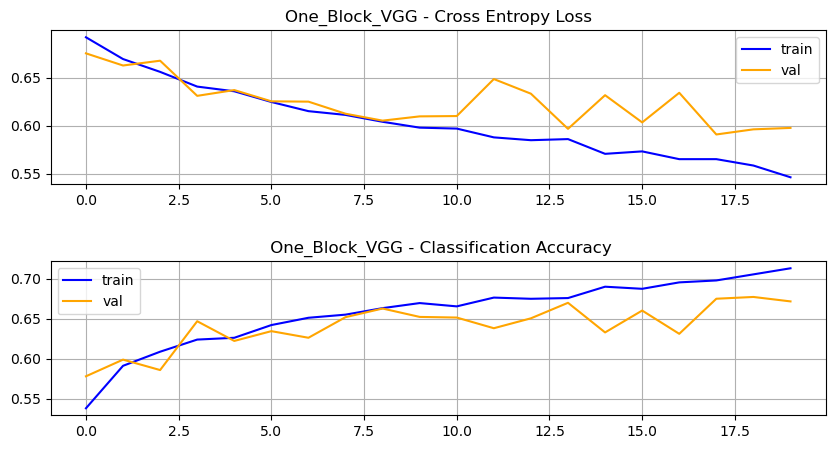

In [12]:
# learning curves
summarize_diagnostics(history, 'One_Block_VGG')

In this case, we can see that the model achieved an accuracy of about 67% on the validation dataset. Reviewing this plot, we can see that the model has slightly overfit the training set.

## Two Blocks VGG Model
The two-block VGG model extends the one block model and adds a second block with 64 filters.

In [13]:
model = define_model(2, [32, 64])

In [14]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/kaggle/working/models/two_block_vgg.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_it, steps_per_epoch=len(train_it),
                    validation_data=val_it, validation_steps=len(val_it), epochs=20, 
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("/kaggle/working/models/two_block_vgg.h5") # rollback to best model

Epoch 1/20
293/293 [==============================] - 114s 381ms/step - loss: 0.6616 - accuracy: 0.5986 - val_loss: 0.6219 - val_accuracy: 0.6526
Epoch 2/20
293/293 [==============================] - 109s 373ms/step - loss: 0.6204 - accuracy: 0.6461 - val_loss: 0.6461 - val_accuracy: 0.6196
Epoch 3/20
293/293 [==============================] - 110s 374ms/step - loss: 0.5990 - accuracy: 0.6719 - val_loss: 0.6254 - val_accuracy: 0.6425
Epoch 4/20
293/293 [==============================] - 109s 372ms/step - loss: 0.5778 - accuracy: 0.6904 - val_loss: 0.5733 - val_accuracy: 0.6982
Epoch 5/20
293/293 [==============================] - 107s 366ms/step - loss: 0.5568 - accuracy: 0.7114 - val_loss: 0.5614 - val_accuracy: 0.7133
Epoch 6/20
293/293 [==============================] - 108s 367ms/step - loss: 0.5315 - accuracy: 0.7337 - val_loss: 0.5453 - val_accuracy: 0.7196
Epoch 7/20
293/293 [==============================] - 107s 365ms/step - loss: 0.5156 - accuracy: 0.7488 - val_loss: 0.5412 -

In [15]:
# evaluate model
_, acc = model.evaluate(val_it, steps=len(val_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 76.674


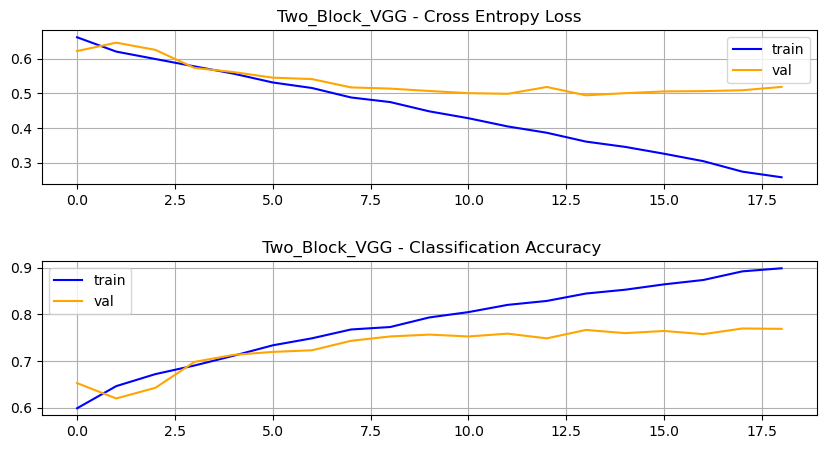

In [16]:
# learning curves
summarize_diagnostics(history, 'Two_Block_VGG')

## Three Blocks VGG Model
The three-block VGG model extends the two block model and adds a third block with 128 filters.

In [17]:
model = define_model(3, [32, 64, 128])

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/kaggle/working/models/three_block_vgg.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_it, steps_per_epoch=len(train_it),
                    validation_data=val_it, validation_steps=len(val_it), epochs=20, 
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("/kaggle/working/models/three_block_vgg.h5") # rollback to best model

Epoch 1/20
293/293 [==============================] - 111s 372ms/step - loss: 0.6576 - accuracy: 0.6080 - val_loss: 0.8507 - val_accuracy: 0.5071
Epoch 2/20
293/293 [==============================] - 108s 368ms/step - loss: 0.6158 - accuracy: 0.6536 - val_loss: 0.5886 - val_accuracy: 0.6922
Epoch 3/20
293/293 [==============================] - 108s 369ms/step - loss: 0.5857 - accuracy: 0.6852 - val_loss: 0.5800 - val_accuracy: 0.6915
Epoch 4/20
293/293 [==============================] - 108s 368ms/step - loss: 0.5587 - accuracy: 0.7121 - val_loss: 0.5745 - val_accuracy: 0.6872
Epoch 5/20
293/293 [==============================] - 109s 372ms/step - loss: 0.5370 - accuracy: 0.7287 - val_loss: 0.5319 - val_accuracy: 0.7366
Epoch 6/20
293/293 [==============================] - 109s 370ms/step - loss: 0.5093 - accuracy: 0.7498 - val_loss: 0.5153 - val_accuracy: 0.7506
Epoch 7/20
293/293 [==============================] - 110s 374ms/step - loss: 0.4937 - accuracy: 0.7595 - val_loss: 0.5108 -

In [19]:
# evaluate model
_, acc = model.evaluate(val_it, steps=len(val_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 79.102


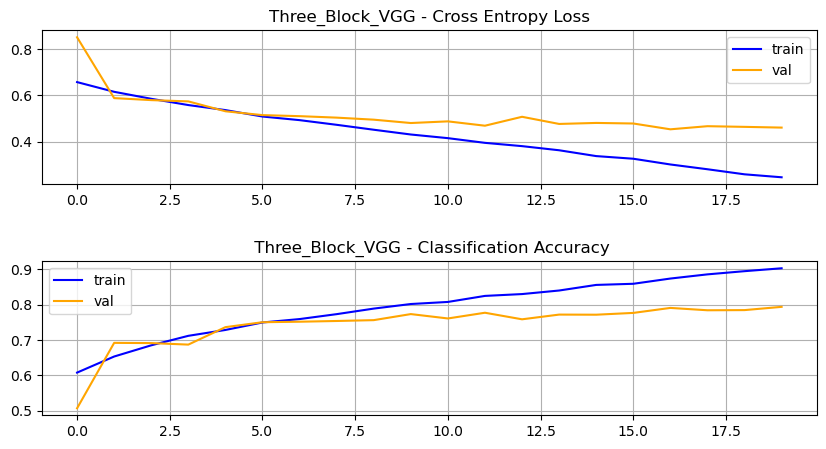

In [20]:
# learning curves
summarize_diagnostics(history, 'Three_Block_VGG')

We have explored three different models with a VGG-based architecture.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

- **VGG 1:** 67.487%
- **VGG 2:** 76.674%
- **VGG 3:** 79.102%

We see a trend of improved performance with the increase in capacity, but also a similar case of overfitting occurring earlier and earlier in the run.

The results suggest that the model will likely benefit from regularization techniques. This may include techniques such as dropout, weight decay, and data augmentation. The latter can also boost performance by encouraging the model to learn features that are further invariant to position by expanding the training dataset.

# Model Improvements
From reviewing the learning curves for the model during training, the model showed strong signs of overfitting. We can explore two approaches to attempt to address this overfitting: dropout regularization and data augmentation.

Both of these approaches are expected to slow the rate of improvement during training and hopefully counter the overfitting of the training dataset. As such, we will increase the number of training epochs from 20 to 50 to give the model more space for refinement.

## Dropout Regularization
Below is the updated `define_model()` function for an updated version of the baseline model with the addition of Dropout. In this case, a dropout of 20% is applied after each VGG block, with a larger dropout rate of 50% applied after the fully connected layer in the classifier part of the model.

In [21]:
from tensorflow import keras

def define_model(n_blocks, n_filters, learning_rate=0.002):
    model = keras.models.Sequential()
    for i in range(n_blocks):
        model.add(keras.layers.Conv2D(n_filters[i], (3, 3), activation="relu", kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # compile model
    opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model = define_model(3, [32, 64, 128])

In [23]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/kaggle/working/models/dropout_three_block_vgg.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_it, steps_per_epoch=len(train_it),
                    validation_data=val_it, validation_steps=len(val_it), epochs=50, 
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("/kaggle/working/models/dropout_three_block_vgg.h5") # rollback to best model

Epoch 1/50


2023-08-20 15:25:38.174462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


293/293 [==============================] - 112s 378ms/step - loss: 0.7210 - accuracy: 0.5134 - val_loss: 0.6895 - val_accuracy: 0.5817
Epoch 2/50
293/293 [==============================] - 109s 373ms/step - loss: 0.6879 - accuracy: 0.5316 - val_loss: 0.6898 - val_accuracy: 0.5643
Epoch 3/50
293/293 [==============================] - 111s 378ms/step - loss: 0.6845 - accuracy: 0.5524 - val_loss: 0.6860 - val_accuracy: 0.5835
Epoch 4/50
293/293 [==============================] - 111s 380ms/step - loss: 0.6793 - accuracy: 0.5647 - val_loss: 0.6829 - val_accuracy: 0.5871
Epoch 5/50
293/293 [==============================] - 110s 376ms/step - loss: 0.6626 - accuracy: 0.5858 - val_loss: 0.6647 - val_accuracy: 0.6371
Epoch 6/50
293/293 [==============================] - 112s 382ms/step - loss: 0.6405 - accuracy: 0.6193 - val_loss: 0.6418 - val_accuracy: 0.6590
Epoch 7/50
293/293 [==============================] - 111s 379ms/step - loss: 0.6223 - accuracy: 0.6389 - val_loss: 0.6273 - val_accura

In [24]:
# evaluate model
_, acc = model.evaluate(val_it, steps=len(val_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 82.101


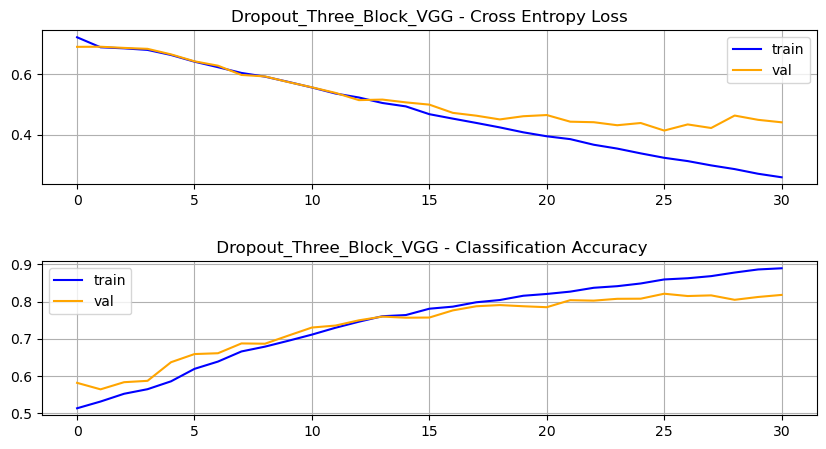

In [25]:
# learning curves
summarize_diagnostics(history, 'Dropout_Three_Block_VGG')

In this case,  we can see an improvement in our model performance from about 79% accuracy for the baseline model to about 82% with the addition of dropout. In addition, overfitting has been reduced and delayed.

The results suggest that further training epochs may result in further improvement of the model. It may also be interesting to explore perhaps a slightly higher dropout rate after the VGG blocks in addition to the increase in training epochs.

## Data Augmentation
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. It can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

Small changes to the input photos of dogs and cats might be useful for this problem, such as small shifts and horizontal flips. These augmentations can be specified as arguments to the ImageDataGenerator used for the training dataset. The augmentations should not be used for the validation or test set, as we wish to evaluate the performance of the model on the unmodified photographs.

This requires that we have a separate ImageDataGenerator instance for the train and validation and test dset, then iterators for the train and validation sets created from the respective data generators.

In [26]:
# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, 
                                   height_shift_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_it = train_datagen.flow_from_directory('/kaggle/input/cats-vs-dogs/train/',
                                       class_mode='binary', batch_size=64, target_size=(224, 224))
val_it = val_datagen.flow_from_directory('/kaggle/input/cats-vs-dogs/val/',
                                      class_mode='binary', batch_size=64, target_size=(224, 224))

Found 18696 images belonging to 2 classes.
Found 6302 images belonging to 2 classes.


In this case, photos in the training dataset will be augmented with small (10%) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the train and val sets will have their pixel values scaled in the same way.

In [27]:
model = define_model(3, [32, 64, 128])

In [28]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/kaggle/working/models/dropout_d_augmented_three_block_vgg.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_it, steps_per_epoch=len(train_it),
                    validation_data=val_it, validation_steps=len(val_it), epochs=50, 
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("/kaggle/working/models/dropout_d_augmented_three_block_vgg.h5") # rollback to best model

Epoch 1/50


2023-08-20 16:29:58.061567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


293/293 [==============================] - 346s 1s/step - loss: 0.7417 - accuracy: 0.5129 - val_loss: 0.6914 - val_accuracy: 0.5760
Epoch 2/50
293/293 [==============================] - 345s 1s/step - loss: 0.6865 - accuracy: 0.5436 - val_loss: 0.6874 - val_accuracy: 0.5728
Epoch 3/50
293/293 [==============================] - 344s 1s/step - loss: 0.6833 - accuracy: 0.5524 - val_loss: 0.6838 - val_accuracy: 0.5925
Epoch 4/50
293/293 [==============================] - 345s 1s/step - loss: 0.6766 - accuracy: 0.5748 - val_loss: 0.6737 - val_accuracy: 0.5971
Epoch 5/50
293/293 [==============================] - 349s 1s/step - loss: 0.6644 - accuracy: 0.5917 - val_loss: 0.6580 - val_accuracy: 0.6414
Epoch 6/50
293/293 [==============================] - 347s 1s/step - loss: 0.6518 - accuracy: 0.6042 - val_loss: 0.6405 - val_accuracy: 0.6612
Epoch 7/50
293/293 [==============================] - 350s 1s/step - loss: 0.6317 - accuracy: 0.6232 - val_loss: 0.6346 - val_accuracy: 0.6719
Epoch 8/50

In [29]:
# evaluate model
_, acc = model.evaluate(val_it, steps=len(val_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 84.291


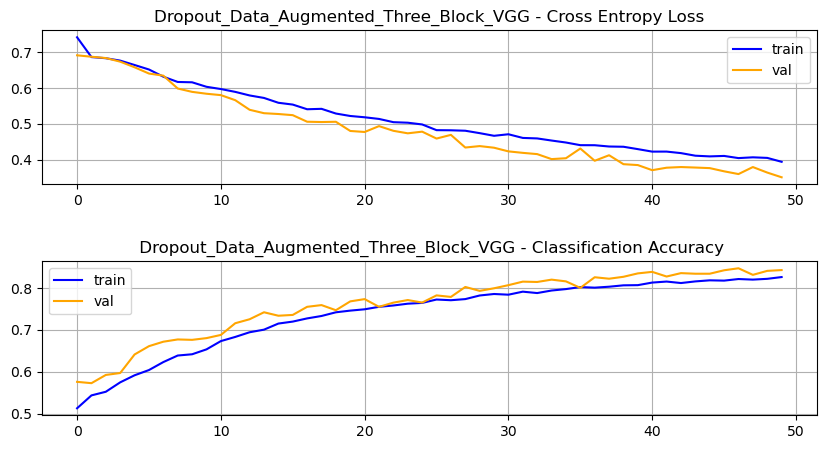

In [30]:
# learning curves
summarize_diagnostics(history, 'Dropout_Data_Augmented_Three_Block_VGG')

# Results
The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

- **Baseline VGG3 + Dropout:** 82.101%
- **Baseline VGG3 + Dropout + Data Augmentation:** 84.291%

As suspected, the addition of regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the validation set. It also seems that the augmentation of the dataset helps the model to generalize to new instances.

This is just the beginning of the types of improvements that can be explored on this dataset. In addition to tweaks to the regularization methods described, other regularization methods could be explored such as Batch Normalization.

Alternate model architectures may also be worth exploring. The chosen baseline model is expected to offer more capacity than may be required for this problem and a smaller model may faster to train and in turn could result in better performance. We could also do some Transfer Learning with a pre-trained model such as VGG-16.